In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import cos, sin, exp, Matrix

from IPython.display import display, Math
from IPython.display import display as disp

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

# Geração de sinais ópticos

Num sistema de comunicação digital óptica, a função do transmissor é converter uma dada sequência de bits num trem de pulsos elétricos que, por sua vez, será utilizado na modulação de uma portadora óptica (laser). A modulação de portadoras ópticas é realizada por meio de dispositivos de conversão eletro-óptica.

<img src="./figuras/Tx_OOK.png" width="500">

Diversas técnicas de modulação podem ser implementadas e diversos fatores podem influenciar o projeto de um transmissor óptico. 

## Formatos de modulação

O campo elétrico $\mathbf{E}(t)$ da portadora óptica portadora óptica de onda contínua pode ser representado por

$$\begin{equation} \mathbf{E}(t) = A \cos \left(\omega_c t + \phi\right) \mathbf{e} \end{equation}$$ 

em que $\omega_c = 2\pi f_{c}\label{eq1} $ rad/s é a frequência angular de oscilação, $A$ a amplitude e $\phi$ a fase da onda.

In [4]:
ϕ, omega_c, A, t = sp.symbols('ϕ, omega_c, A, t', real=True)

j = sp.I
π = sp.pi

E = A*cos(omega_c*t + ϕ)

disp(Math('E(t) = '+sp.latex(E)))

<IPython.core.display.Math object>

$\mathbf{E}(t)=\operatorname{Re}\left[A e^{j \phi} \exp \left(j \omega_c t\right)\right]$

In [5]:
E = sp.re(A*exp(j*ϕ)*exp(j*omega_c*t)).simplify()

disp(Math('E(t) = '+sp.latex(E)))

<IPython.core.display.Math object>

In [6]:
E = sp.expand_trig(E).cancel()

disp(Math('E(t) = '+sp.latex(E)))

<IPython.core.display.Math object>

## Modulador de Mach-Zehnder


<img src="./figuras/MZM.png" width="600">


$$\begin{equation}
\left[\begin{array}{l}
\hat{E}_{1} \\
\hat{E}_{2}
\end{array}\right]=\frac{1}{2}\left[\begin{array}{ll}
1 & j \\
j & 1
\end{array}\right]\left[\begin{array}{cc}
e^{j \phi_{1}} & 0 \\
0 & e^{j \phi_{2}}
\end{array}\right]\left[\begin{array}{ll}
1 & j \\
j & 1
\end{array}\right]\left[\begin{array}{c}
\hat{E}_{i} \\
0
\end{array}\right]
\end{equation}$$

In [7]:
ϕ1, ϕ2 = sp.symbols('ϕ1, ϕ2', real=True)
Ei     = sp.symbols('E_i', complex=True)

C  = Matrix([[1, j],[j, 1]])
MZ = Matrix([[exp(j*ϕ1), 0],[0, exp(j*ϕ2)]])

E = Matrix([[Ei],[0]])

T = (1/2)*C*MZ*C

H = T*E
H

Matrix([
[    E_i*(0.5*exp(I*ϕ1) - 0.5*exp(I*ϕ2))],
[E_i*(0.5*I*exp(I*ϕ1) + 0.5*I*exp(I*ϕ2))]])

$$\begin{equation}
\frac{\hat{E}_{\text {out }}(t)}{\hat{E}_{\text {in }}(t)}=\frac{1}{2} \left(e^{j \varphi(t)}+e^{-j \varphi(t)}\right)e^{j\frac{\pi}{2}}
\end{equation}$$

$$
\varphi(t)=\frac{1}{2V_{\pi}}[u(t)+V_b]\pi
$$

$$\begin{equation}
A_{\text {out}}(t) = A_{i n}(t) \cos \left(\frac{1}{2V_{\pi}}[u(t)+V_b]\pi\right)
\end{equation}$$

In [8]:
def mzm(Ai, Vπ, u, Vb):
    """
    Modulador MZM
    
    :param Vπ: tensão Vπ
    :param Vb: tensão de bias
    :param u:  sinal modulante
    :param Ai: amplitude da portadora CW
    
    :return Ao: amplitude da portadora modulada
    """
    π  = np.pi
    Ao = Ai*np.cos(0.5/Vπ*(u+Vb)*π)
    
    return Ao
    

## Transmitindo informação na intensidade (potência) da portadora óptica

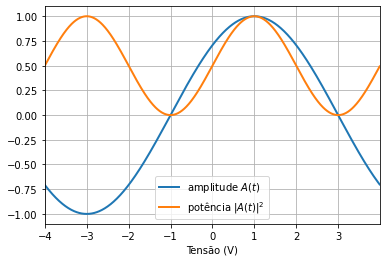

In [9]:
Vπ = 2
Vb = -Vπ/2

u = np.arange(-2*Vπ, 2*Vπ, 0.01)

Ai = 1
Ao = mzm(Ai, Vπ, u, Vb)

plt.figure(figsize=(6,4))
plt.plot(u, Ao, label = 'amplitude $A(t)$', linewidth = 2);
plt.xlabel('Tensão (V)')
plt.xlim(min(u), max(u));

plt.plot(u, np.abs(Ao)**2, label = 'potência $|A(t)|^2$', linewidth = 2);
plt.xlabel('Tensão (V)')
plt.xlim(min(u), max(u));
plt.legend()
plt.grid()

## Transmitindo informação na amplitude do campo elétrico

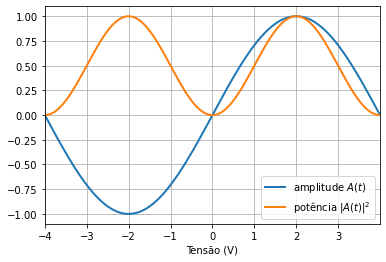

In [10]:
Vπ = 2
Vb = -Vπ

u = np.arange(-2*Vπ, 2*Vπ, 0.01)

Ai = 1

Ao = mzm(Ai, Vπ, u, Vb)

plt.figure(figsize=(6,4))
plt.plot(u, Ao, label = 'amplitude $A(t)$', linewidth = 2);
plt.xlabel('Tensão (V)')
plt.xlim(min(u), max(u));

plt.plot(u, np.abs(Ao)**2, label = 'potência $|A(t)|^2$', linewidth = 2);
plt.xlabel('Tensão (V)')
plt.xlim(min(u), max(u));
plt.legend()
plt.grid()

### Chaveamento por deslocamento de amplitude (*amplitude shift-keying* - ASK) ou modulação de amplitude de pulso (*pulse amplitude modulation* - PAM)

$ E(t)=\operatorname{Re}\left[A(t) e^{j \phi} \exp \left(j \omega_c t\right)\right]$

$$ \begin{align} A(t) &= \sqrt{P_{0}} \left[ \sum_{n} b_{n} \delta \left(t-n T_{s}\right)\right] \ast p(t) \nonumber \\ & = \sqrt{P_{0}} \sum_{n} b_{n} p\left(t-n T_{s}\right)\end{align}$$

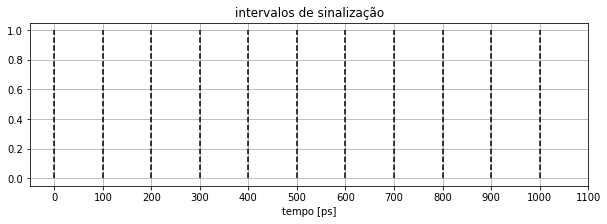

In [11]:
Rs  = 10e9          # Taxa de símbolos (baud rate)
Ts  = 1/Rs          # Período de símbolo em segundos

t = np.arange(0, 11*Ts, Ts)/1e-12

for ind in range(0, 11):
    plt.vlines(t[ind], 0, 1, linestyles='dashed', color = 'k')
    
plt.xlabel('tempo [ps]');
plt.title('intervalos de sinalização');
plt.grid()
plt.xticks(t);

In [12]:
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram

In [13]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
P0     = 1             # Potência

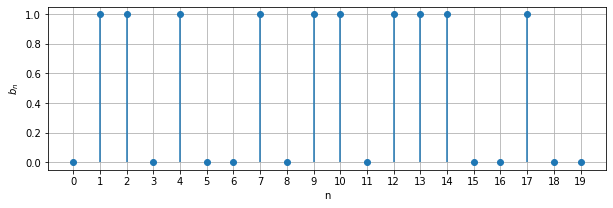

In [14]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=20)    
n      = np.arange(0, bits.size)

# mapeia bits para símbolos binários
symbTx = np.sqrt(P0)*(2*bits-1)

plt.figure(1)
plt.stem(bits, basefmt=" ", use_line_collection=True)
plt.xlabel('n')
plt.ylabel('$b_n$')
plt.grid()
plt.xticks(np.arange(0, bits.size));

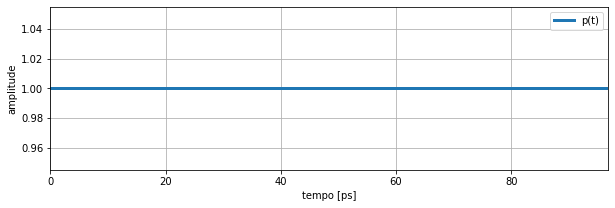

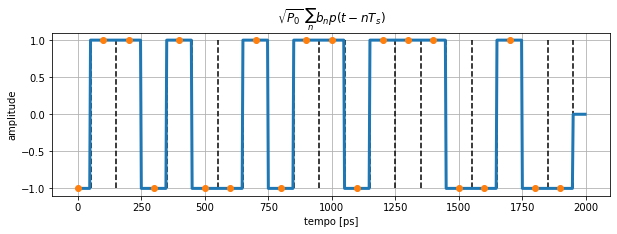

In [15]:
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso retangular ideal
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend()

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

# plota sinal 
t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
#symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-', linewidth=3)
plt.plot(t, symbolsUp.real, 'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.title('$\sqrt{P_0}\; \sum_{n}b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
for ind in range(0, bits.size):
    plt.vlines(t[ind], -1, 1, linestyles='dashed', color = 'k')

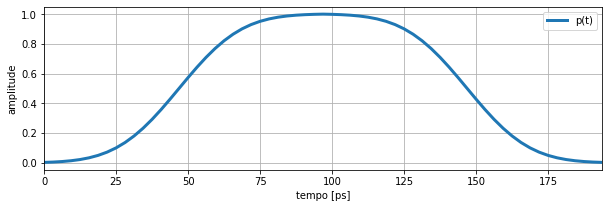

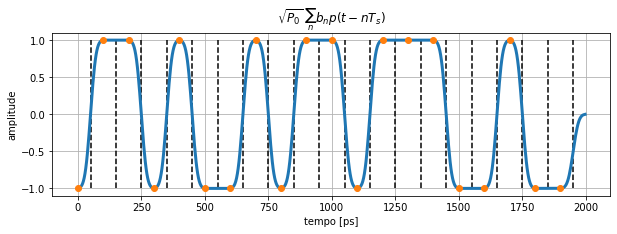

In [16]:
# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend()

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
#symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-',linewidth=3)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.title('$\sqrt{P_0}\; \sum_{n}b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
for ind in range(0, bits.size):
    plt.vlines(t[ind], -1, 1, linestyles='dashed', color = 'k')

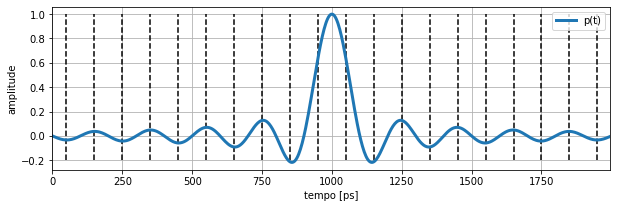

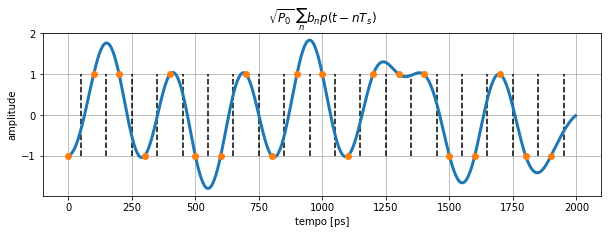

In [17]:
# pulso cosseno levantado (raised cosine)
Ncoeffs = 640
rolloff = 0.01

pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend()

t = (-0.0*Ts + np.arange(0, (Ncoeffs/SpS)*Ts, Ts))/1e-12
for ind in range(0, t.size):    
    plt.vlines(t[ind] + 0.5*(Ts/1e-12), -0.2, 1, linestyles='dashed', color = 'k')

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso 
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
#symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-', linewidth=3)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.title('$\sqrt{P_0}\; \sum_{n}b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
for ind in range(0, bits.size):
    plt.vlines(t[ind], -1, 1, linestyles='dashed', color = 'k')

## Densidade espectral de potência do sinal modulado

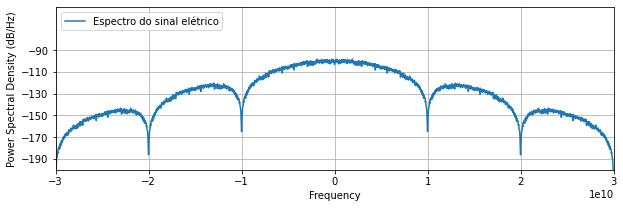

In [18]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = np.sqrt(P0)*symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# # pulso cosseno levantado (raised cosine)
# Ncoeffs = 640
# rolloff = 0.1

# pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
# pulse = pulse/max(abs(pulse))

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

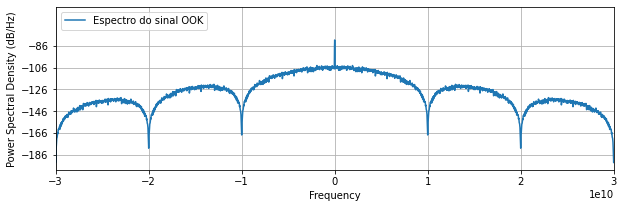

In [19]:

Vπ = 2 
Vb = -Vπ/2
Ai = 1

sigTxo = mzm(Ai, Vπ, sigTx, Vb)

# plota psd
plt.figure();
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

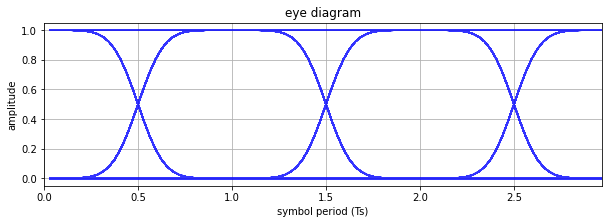

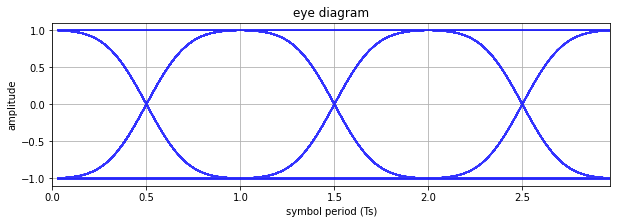

In [20]:
Nsamples = 10000

# diagrama de olho
eyediagram(np.abs(sigTxo)**2, Nsamples, SpS)
eyediagram(sigTx, Nsamples, SpS)

### PAM4

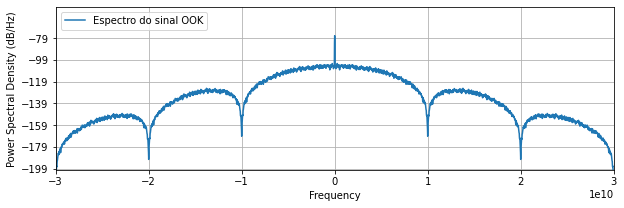

In [21]:
# gera sequência de bits pseudo-aleatórios
bits1   = np.random.randint(2, size=10000)  
bits2   = np.random.randint(2, size=10000) 

n      = np.arange(0, bits.size)

# mapeia bits para símbolos PAM4
symbTx = (2/3)*bits1 + (1/3)*bits2
symbTx = np.sqrt(P0)*symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

In [22]:
Nsamples = 20000

# # diagrama de olho
# eyediagram(sigTx, Nsamples, SpS)

### QPSK

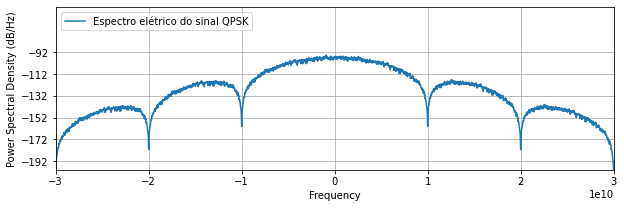

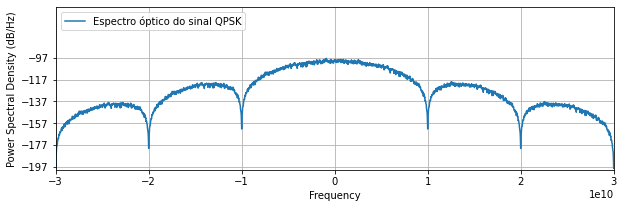

In [23]:
# gera sequência de bits pseudo-aleatórios
bitsI   = np.random.randint(2, size=10000)  
bitsQ   = np.random.randint(2, size=10000) 

n  = np.arange(0, bits.size)

# mapeia bits para símbolos 
symbTx_I = 2*bitsI-1
symbTx_Q = 2*bitsQ-1

symbTx_I = symbTx_I/np.sqrt(signal_power(symbTx_I))
symbTx_Q = symbTx_Q/np.sqrt(signal_power(symbTx_Q))

symbTx = symbTx_I + 1j*symbTx_Q

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro elétrico do sinal QPSK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);


Vπ = 2 
Vb = -Vπ
Ai = 1

sigTxo_I = mzm(Ai, Vπ, sigTx.real, Vb)
sigTxo_Q = mzm(Ai, Vπ, sigTx.imag, Vb)

sigTxo = sigTxo_I + 1j*sigTxo_Q

# plota psd
plt.figure();
plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico do sinal QPSK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

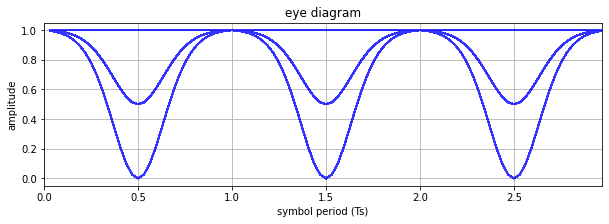

In [24]:
Nsamples = 10000

# diagrama de olho
eyediagram(np.abs(sigTxo)**2, Nsamples, SpS)

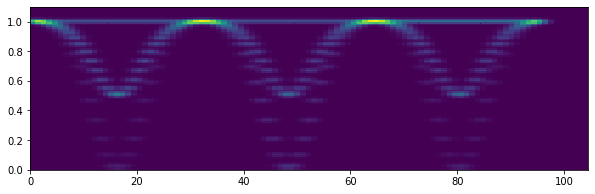

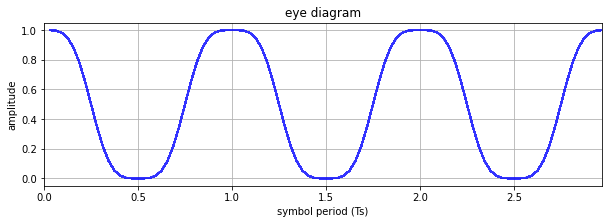

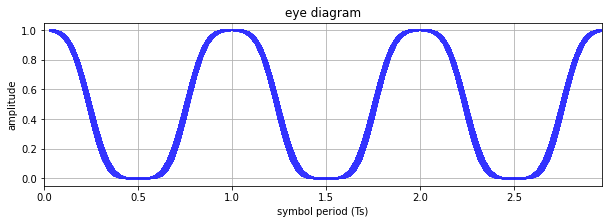

In [25]:
t = np.arange(0, sigTxo.size)*Ta

Vπ = 2 
Vb = Vπ/2
Ai = 1

senoideRF = Vπ/2*np.cos(2*np.pi*Rs*t + np.pi)

sigTxo_   = mzm(sigTxo, Vπ, senoideRF, Vb)

Nsamples = 10000

# diagrama de olho
eyediagram(np.abs(sigTxo)**2, Nsamples, SpS, ptype='fancy', plotlabel='óptico')
eyediagram(np.abs(mzm(Ai, Vπ, senoideRF, Vb))**2, Nsamples, SpS)
eyediagram(np.abs(sigTxo_)**2, Nsamples, SpS)

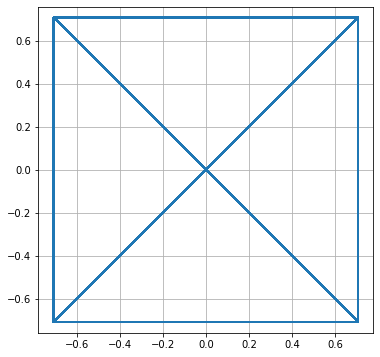

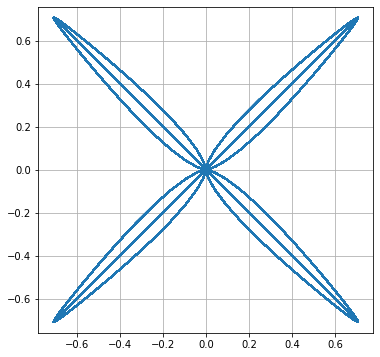

In [26]:
plt.figure(figsize=(6,6))
plt.plot(sigTxo.real,sigTxo.imag)
plt.grid()
plt.axis('equal');

plt.figure(figsize=(6,6))
plt.plot(sigTxo_.real,sigTxo_.imag)
plt.grid()
plt.axis('equal');